# Regularization and Evaluation of Neural Networks

<a href="https://colab.research.google.com/github/flatiron-school/NTL01-DTSC-LIVE-040323/blob/main/4phase/63-network_regularization_and_evaluation.ipynb" 
target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision

from scikeras.wrappers import KerasClassifier

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# !pip install scikeras

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [3]:
digits = load_digits()
X = digits.data.astype('float32')
y = digits.target.astype('float32')

y_binary = y % 2

In [4]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 4s 5ms/step - loss: 0.6288 - accuracy: 0.6962
Epoch 2/50
180/180 [==============================] - 1s 5ms/step - loss: 0.3106 - accuracy: 0.8642: 0s - loss: 0
Epoch 3/50
180/180 [==============================] - 1s 6ms/step - loss: 0.2264 - accuracy: 0.8943
Epoch 4/50
180/180 [==============================] - 1s 5ms/step - loss: 0.1801 - accuracy: 0.9204
Epoch 5/50
180/180 [==============================] - 1s 5ms/step - loss: 0.1466 - accuracy: 0.9377
Epoch 6/50
180/180 [==============================] - 1s 5ms/step - loss: 0.1267 - accuracy: 0.9449
Epoch 7/50
180/180 [==============================] - 1s 5ms/step - loss: 0.1096 - accuracy: 0.9544
Epoch 8/50
180/180 [==============================] - 1s 5ms/step - loss: 0.0940 - accuracy: 0.9605
Epoch 9/50
180/180 [==============================] - 1s 5ms/step - loss: 0.0795 - accuracy: 0.9610: 0s - loss: 0
Epoch 10/50
180/180 [==============================] - 1s 5ms/step - los

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [5]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [6]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6964 - accuracy: 0.4961
Epoch 2/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6960 - accuracy: 0.4961
Epoch 3/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6956 - accuracy: 0.4961
Epoch 4/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.4978
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.5013
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6949 - accuracy: 0.5013
Epoch 7/10
12/12 [==============================] - 0s 6ms/step - loss: 0.6947 - accuracy: 0.5048
Epoch 8/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6945 - accuracy: 0.5083
Epoch 9/10
12/12 [==============================] - 0s 6ms/step - loss: 0.6943 - accuracy: 0.4900
Epoch 10/10
12/12 [==============================] - 0s 6ms/step - loss: 0.6942 - accuracy: 0.4900


We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [7]:
results.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x179c21bd0a0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.6964426636695862,
   0.6959898471832275,
   0.6956378221511841,
   0.6953132152557373,
   0.6950796246528625,
   0.6948687434196472,
   0.6946531534194946,
   0.6945031881332397,
   0.694327175617218,
   0.694161057472229],
  'accuracy': [0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.49782419204711914,
   0.5013054609298706,
   0.5013054609298706,
   0.5047867894172668,
   0.5082680583000183,
   0.48999130725860596,
   0.48999130725860596]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

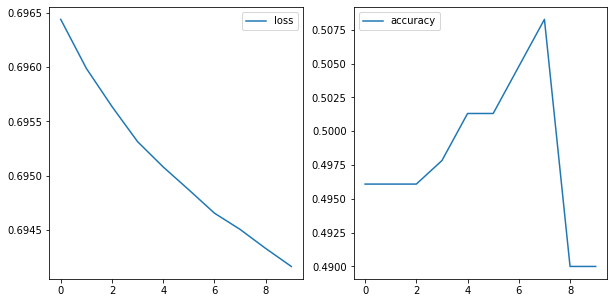

In [8]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [9]:
X_pure_train.shape[0]

1149

In [10]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=None, verbose=1)

Epoch 1/100
36/36 [==============================] - 1s 5ms/step - loss: 0.7167 - accuracy: 0.5004
Epoch 2/100
36/36 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.5335
Epoch 3/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6706 - accuracy: 0.5744
Epoch 4/100
36/36 [==============================] - 0s 4ms/step - loss: 0.6557 - accuracy: 0.6171
Epoch 5/100
36/36 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6519
Epoch 6/100
36/36 [==============================] - 0s 4ms/step - loss: 0.6265 - accuracy: 0.6797
Epoch 7/100
36/36 [==============================] - 0s 4ms/step - loss: 0.6124 - accuracy: 0.6971
Epoch 8/100
36/36 [==============================] - 0s 6ms/step - loss: 0.5987 - accuracy: 0.7267
Epoch 9/100
36/36 [==============================] - 0s 4ms/step - loss: 0.5845 - accuracy: 0.7476
Epoch 10/100
36/36 [==============================] - 0s 4ms/step - loss: 0.5690 - accuracy: 0.7641
Epoch 11/

36/36 [==============================] - 0s 5ms/step - loss: 0.1789 - accuracy: 0.9234
Epoch 83/100
36/36 [==============================] - 0s 4ms/step - loss: 0.1768 - accuracy: 0.9234
Epoch 84/100
36/36 [==============================] - 0s 4ms/step - loss: 0.1748 - accuracy: 0.9208
Epoch 85/100
36/36 [==============================] - 0s 5ms/step - loss: 0.1734 - accuracy: 0.9225
Epoch 86/100
36/36 [==============================] - 0s 4ms/step - loss: 0.1732 - accuracy: 0.9208
Epoch 87/100
36/36 [==============================] - 0s 4ms/step - loss: 0.1711 - accuracy: 0.9252
Epoch 88/100
36/36 [==============================] - 0s 4ms/step - loss: 0.1703 - accuracy: 0.9269
Epoch 89/100
36/36 [==============================] - 0s 4ms/step - loss: 0.1690 - accuracy: 0.9225
Epoch 90/100
36/36 [==============================] - 0s 4ms/step - loss: 0.1678 - accuracy: 0.9286
Epoch 91/100
36/36 [==============================] - 0s 4ms/step - loss: 0.1659 - accuracy: 0.9252
Epoch 92/100


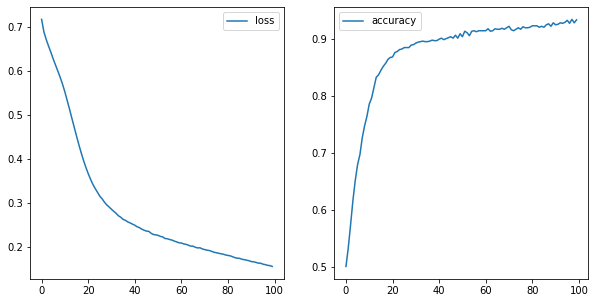

In [11]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
115/115 [==============================] - 1s 4ms/step - loss: 50.3543 - accuracy: 0.4970
Epoch 2/30
115/115 [==============================] - 0s 4ms/step - loss: 1.0363 - accuracy: 0.4935
Epoch 3/30
115/115 [==============================] - 0s 4ms/step - loss: 1.0368 - accuracy: 0.4970
Epoch 4/30
115/115 [==============================] - 0s 4ms/step - loss: 1.0512 - accuracy: 0.4813
Epoch 5/30
115/115 [==============================] - 0s 4ms/step - loss: 0.9706 - accuracy: 0.5187
Epoch 6/30
115/115 [==============================] - 0s 4ms/step - loss: 0.9667 - accuracy: 0.5004
Epoch 7/30
115/115 [==============================] - 0s 4ms/step - loss: 0.9636 - accuracy: 0.4952
Epoch 8/30
115/115 [==============================] - 0s 4ms/step - loss: 1.0755 - accuracy: 0.4700
Epoch 9/30
115/115 [==============================] - 0s 4ms/step - loss: 1.0294 - accuracy: 0.5013
Epoch 10/30
115/115 [==============================] - 0s 4ms/step - loss: 1.0534 - accuracy: 0.480

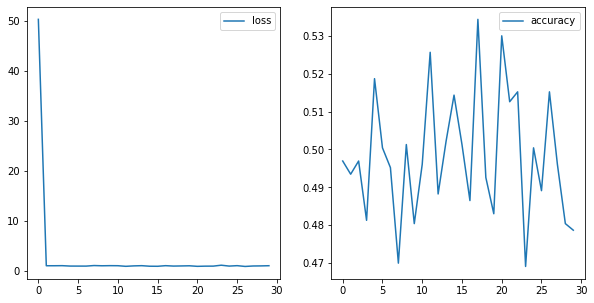

In [13]:
model = Sequential()

# sgd = SGD(learning_rate=9)
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=SGD(learning_rate=9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

In [14]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)

Epoch 1/30
115/115 [==============================] - 1s 8ms/step - loss: 0.6552 - accuracy: 0.5344 - val_loss: 0.5859 - val_accuracy: 0.6944
Epoch 2/30
115/115 [==============================] - 1s 6ms/step - loss: 0.5174 - accuracy: 0.8129 - val_loss: 0.4406 - val_accuracy: 0.8750
Epoch 3/30
115/115 [==============================] - 1s 7ms/step - loss: 0.3665 - accuracy: 0.8842 - val_loss: 0.2881 - val_accuracy: 0.9028
Epoch 4/30
115/115 [==============================] - 1s 6ms/step - loss: 0.2479 - accuracy: 0.9138 - val_loss: 0.2435 - val_accuracy: 0.9167
Epoch 5/30
115/115 [==============================] - 1s 6ms/step - loss: 0.1936 - accuracy: 0.9295 - val_loss: 0.1837 - val_accuracy: 0.9271
Epoch 6/30
115/115 [==============================] - 1s 6ms/step - loss: 0.1582 - accuracy: 0.9434 - val_loss: 0.1503 - val_accuracy: 0.9479
Epoch 7/30
115/115 [==============================] - 1s 5ms/step - loss: 0.1369 - accuracy: 0.9478 - val_loss: 0.1221 - val_accuracy: 0.9479
Epoch 

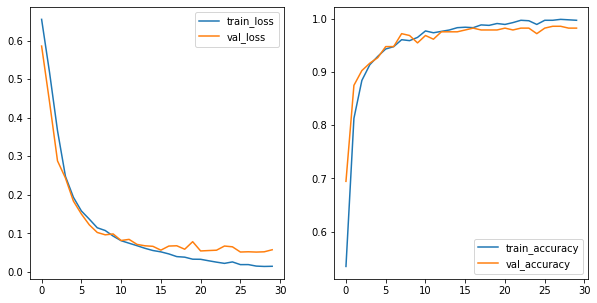

In [16]:
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [17]:
results.history['val_accuracy'][-1]

0.9826388955116272

In [18]:
results.history['accuracy'][-1]

0.997389018535614

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [19]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x00000179977AF940> does not.

In [ ]:
model.

In [21]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [22]:
keras_model = KerasClassifier(build_model,
                                          epochs=50,
                                          batch_size=32,
                                          verbose=2)

In [23]:
type(keras_model)

scikeras.wrappers.KerasClassifier

In [24]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Epoch 1/50
29/29 - 1s - loss: 0.6876 - accuracy: 0.5267 - 636ms/epoch - 22ms/step
Epoch 2/50
29/29 - 0s - loss: 0.6622 - accuracy: 0.6616 - 147ms/epoch - 5ms/step
Epoch 3/50
29/29 - 0s - loss: 0.6249 - accuracy: 0.7922 - 151ms/epoch - 5ms/step
Epoch 4/50
29/29 - 0s - loss: 0.5651 - accuracy: 0.8324 - 126ms/epoch - 4ms/step
Epoch 5/50
29/29 - 0s - loss: 0.4863 - accuracy: 0.8738 - 113ms/epoch - 4ms/step
Epoch 6/50
29/29 - 0s - loss: 0.4003 - accuracy: 0.8749 - 116ms/epoch - 4ms/step
Epoch 7/50
29/29 - 0s - loss: 0.3301 - accuracy: 0.8803 - 109ms/epoch - 4ms/step
Epoch 8/50
29/29 - 0s - loss: 0.2871 - accuracy: 0.8901 - 106ms/epoch - 4ms/step
Epoch 9/50
29/29 - 0s - loss: 0.2583 - accuracy: 0.9064 - 135ms/epoch - 5ms/step
Epoch 10/50
29/29 - 0s - loss: 0.2368 - accuracy: 0.9108 - 126ms/epoch - 4ms/step
Epoch 11/50
29/29 - 0s - loss: 0.2172 - accuracy: 0.9195 - 132ms/epoch - 5ms/step
Epoch 12/50
29/29 - 0s - loss: 0.2012 - accuracy: 0.9217 - 121ms/epoch - 4ms/step
Epoch 13/50
29/29 - 0s -

8/8 - 0s - 82ms/epoch - 10ms/step
Epoch 1/50
29/29 - 1s - loss: 0.6898 - accuracy: 0.5952 - 1s/epoch - 37ms/step
Epoch 2/50
29/29 - 0s - loss: 0.6652 - accuracy: 0.6790 - 158ms/epoch - 5ms/step
Epoch 3/50
29/29 - 0s - loss: 0.6131 - accuracy: 0.7758 - 142ms/epoch - 5ms/step
Epoch 4/50
29/29 - 0s - loss: 0.5318 - accuracy: 0.8281 - 141ms/epoch - 5ms/step
Epoch 5/50
29/29 - 0s - loss: 0.4471 - accuracy: 0.8509 - 207ms/epoch - 7ms/step
Epoch 6/50
29/29 - 0s - loss: 0.3767 - accuracy: 0.8596 - 162ms/epoch - 6ms/step
Epoch 7/50
29/29 - 0s - loss: 0.3269 - accuracy: 0.8792 - 164ms/epoch - 6ms/step
Epoch 8/50
29/29 - 0s - loss: 0.2940 - accuracy: 0.8803 - 188ms/epoch - 6ms/step
Epoch 9/50
29/29 - 0s - loss: 0.2762 - accuracy: 0.8868 - 160ms/epoch - 6ms/step
Epoch 10/50
29/29 - 0s - loss: 0.2545 - accuracy: 0.8912 - 168ms/epoch - 6ms/step
Epoch 11/50
29/29 - 0s - loss: 0.2400 - accuracy: 0.9086 - 117ms/epoch - 4ms/step
Epoch 12/50
29/29 - 0s - loss: 0.2265 - accuracy: 0.9064 - 118ms/epoch - 4m

8/8 - 0s - 69ms/epoch - 9ms/step
Epoch 1/50
29/29 - 1s - loss: 0.6562 - accuracy: 0.6446 - 683ms/epoch - 24ms/step
Epoch 2/50
29/29 - 0s - loss: 0.6034 - accuracy: 0.7380 - 99ms/epoch - 3ms/step
Epoch 3/50
29/29 - 0s - loss: 0.5358 - accuracy: 0.7707 - 116ms/epoch - 4ms/step
Epoch 4/50
29/29 - 0s - loss: 0.4590 - accuracy: 0.7891 - 112ms/epoch - 4ms/step
Epoch 5/50
29/29 - 0s - loss: 0.3963 - accuracy: 0.8141 - 103ms/epoch - 4ms/step
Epoch 6/50
29/29 - 0s - loss: 0.3435 - accuracy: 0.8630 - 116ms/epoch - 4ms/step
Epoch 7/50
29/29 - 0s - loss: 0.3018 - accuracy: 0.8793 - 125ms/epoch - 4ms/step
Epoch 8/50
29/29 - 0s - loss: 0.2696 - accuracy: 0.8946 - 128ms/epoch - 4ms/step
Epoch 9/50
29/29 - 0s - loss: 0.2487 - accuracy: 0.9022 - 107ms/epoch - 4ms/step
Epoch 10/50
29/29 - 0s - loss: 0.2270 - accuracy: 0.9065 - 116ms/epoch - 4ms/step
Epoch 11/50
29/29 - 0s - loss: 0.2138 - accuracy: 0.9109 - 119ms/epoch - 4ms/step
Epoch 12/50
29/29 - 0s - loss: 0.2051 - accuracy: 0.9152 - 110ms/epoch - 4

array([0.95652174, 0.94782609, 0.94347826, 0.97826087, 0.95196507])

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

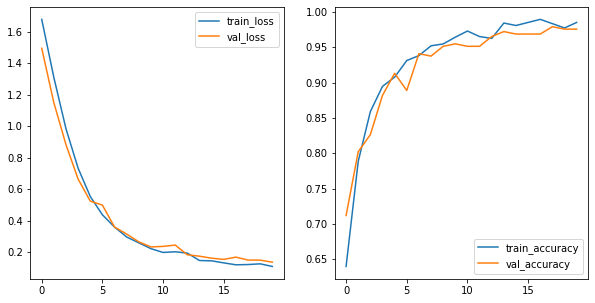

In [25]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Adding L2 to multiple layers:

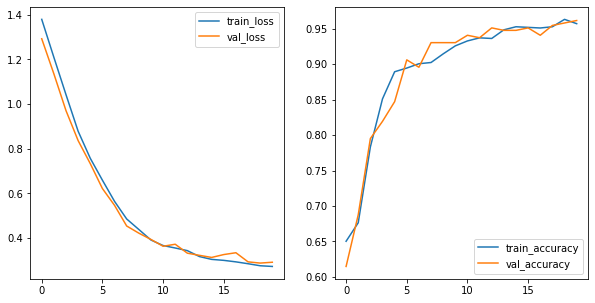

In [26]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

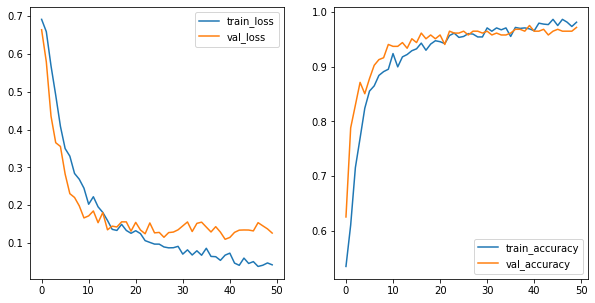

In [27]:
# model.add(Dropout(0.5))

model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(12, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))








train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [28]:
results.history['val_accuracy'][-1]

0.9722222089767456

In [29]:
results.history['accuracy'][-1]

0.9817232489585876

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 00002: early stopping


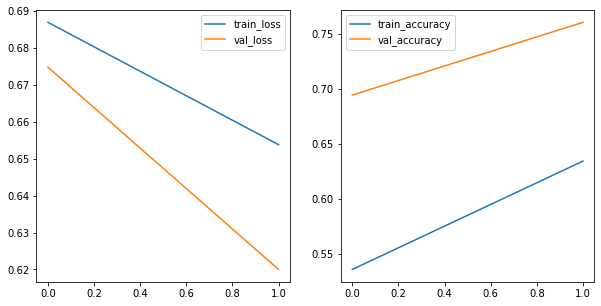

In [34]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-4,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 00026: early stopping


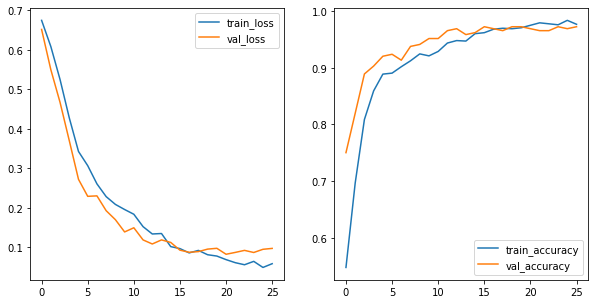

In [35]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, patience=5,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object



# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [36]:
results.history['val_accuracy'][-1]

0.9722222089767456

In [37]:
results.history['accuracy'][-1]

0.9765012860298157

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [43]:
digits = load_digits()
X = digits.data
y = digits.target

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [45]:
y_test[0]

6

In [46]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [47]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [56]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision()])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 2s 9ms/step - loss: 2.2270 - accuracy: 0.2176 - precision: 0.0000e+00 - val_loss: 2.1318 - val_accuracy: 0.2535 - val_precision: 0.0000e+00
Epoch 2/50
115/115 [==============================] - 1s 7ms/step - loss: 1.9057 - accuracy: 0.3168 - precision: 1.0000 - val_loss: 1.7368 - val_accuracy: 0.3993 - val_precision: 1.0000
Epoch 3/50
115/115 [==============================] - 1s 8ms/step - loss: 1.4786 - accuracy: 0.5474 - precision: 0.9895 - val_loss: 1.3260 - val_accuracy: 0.6736 - val_precision: 1.0000
Epoch 4/50
115/115 [==============================] - ETA: 0s - loss: 1.1177 - accuracy: 0.7179 - precision: 0.98 - 1s 7ms/step - loss: 1.1145 - accuracy: 0.7198 - precision: 0.9830 - val_loss: 1.0379 - val_accuracy: 0.7431 - val_precision: 0.9615
Epoch 5/50
115/115 [==============================] - 1s 7ms/step - loss: 0.8640 - accuracy: 0.7876 - precision: 0.9488 - val_loss: 0.8486 - val_accuracy: 0.7639 - val_precision: 0.9586


115/115 [==============================] - 1s 7ms/step - loss: 0.1000 - accuracy: 0.9748 - precision: 0.9789 - val_loss: 0.1884 - val_accuracy: 0.9306 - val_precision: 0.9399
Epoch 45/50
115/115 [==============================] - 1s 6ms/step - loss: 0.0976 - accuracy: 0.9721 - precision: 0.9746 - val_loss: 0.1740 - val_accuracy: 0.9375 - val_precision: 0.9470
Epoch 46/50
115/115 [==============================] - 1s 6ms/step - loss: 0.0937 - accuracy: 0.9791 - precision: 0.9834 - val_loss: 0.1782 - val_accuracy: 0.9375 - val_precision: 0.9406
Epoch 47/50
115/115 [==============================] - 1s 6ms/step - loss: 0.0907 - accuracy: 0.9791 - precision: 0.9816 - val_loss: 0.1676 - val_accuracy: 0.9375 - val_precision: 0.9401
Epoch 48/50
115/115 [==============================] - 1s 6ms/step - loss: 0.0918 - accuracy: 0.9774 - precision: 0.9799 - val_loss: 0.1709 - val_accuracy: 0.9340 - val_precision: 0.9470
Epoch 49/50
115/115 [==============================] - 1s 6ms/step - loss: 0.

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [49]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

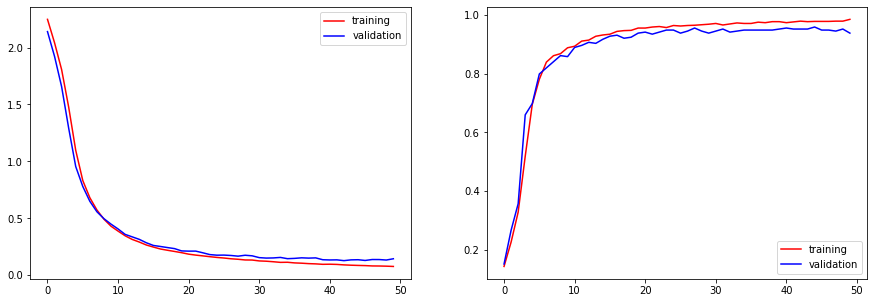

In [50]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [51]:
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

In [52]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

array([[31,  0,  0,  0,  1,  1,  0,  0,  0,  0],
       [ 0, 27,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 31,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 45,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 45,  0,  0,  1,  1],
       [ 1,  0,  0,  0,  0,  0, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 33,  0,  0],
       [ 0,  1,  0,  0,  0,  1,  0,  0, 28,  0],
       [ 0,  1,  0,  4,  0,  0,  0,  2,  0, 33]], dtype=int64)

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
